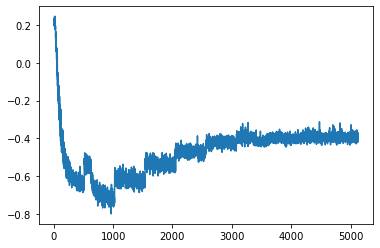

In [1]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

import numpy as np
import matplotlib.pyplot as plt

import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

loss = np.load('../losses_03.npy')

plt.figure()
plt.plot(loss)
plt.show()

In [16]:
import torch
from model import ARSegmentationNet
from dataloader import Potsdam, PotsdamDataLoader

# get the dataloader
path = '/mnt/D2/Data/potsdam/preprocessed/'
validation_dataset = Potsdam(path, split='labelled_test', is_test=True)
validation_loader = PotsdamDataLoader(validation_dataset, batch_size=10)

# get a batch of images and labels from the dataloader
dataiter = iter(validation_loader)


In [4]:
images, labels = dataiter.next()
labels = labels.detach().numpy()

# load the model architecture and trained weights
state_dict = torch.load('../model_03.pth')
model = ARSegmentationNet()
model.load_state_dict(state_dict)

# run the model on the images
out = model(images, 0).detach().numpy()
print(out.shape)
out_preds = np.argmax(out, axis=1)

# labels[labels == 4] = 0 # merge road and cars classes...? this seems questionable but that's how they do
# labels[labels == 5] = 1 # merge buildings and clutter classes
# labels[labels == 3] = 2 # merge vegetation and trees classes

(10, 6, 200, 200)


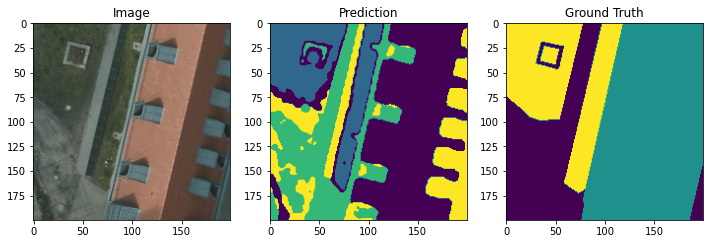

In [15]:
img = 9

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(images[img,:3,:,:].permute(1,2,0)/255)
plt.title("Image")
plt.subplot(132)
plt.imshow(out_preds[img,:,:])
plt.title("Prediction")
plt.subplot(133)
plt.imshow(labels[img,:,:])
plt.title("Ground Truth")
plt.show()
# plt.savefig("out3.png", dpi=300)